# Market analysis and prediction

Inspiré de [Victoria Miller sur kaggle](https://www.kaggle.com/code/victoriamiller19/predicting-stock-prices-with-deep-neural-networks/notebook)
### Objective:
- access market data : yahoo finance limited access, alpha_vantage free!
- plot market data
- train LSTM model to predict stock price

Author: Y. Lacroix

%pip install Yahoo-ticker-downloader

%pip install yfinance

%pip install alpha_vantage

In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import as_strided
import yfinance as yf
import os,time, json,pickle
from alpha_vantage.timeseries import TimeSeries 
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset

### Aller chercher des infos sur les cinquante plus grosses compagnies du SPX 500
- créer une classe Company
- créer un dico avec comme clef les acronymes des entreprises dans le stock, et des valeurs à ajouter
- enrichir la classe au fil de l'eau en la dotant de méthodes etc. 

In [115]:
#clef API pour accéder aux données de alpha_vantage (gratuite)
API_KEY=open("alpha_api_key.txt","r").read()

In [116]:
# Liste des 50 plus grosses capitalisations du SPX500 : ticker, Nom, secteur, industrie
#génère un json pour l'enregistrer
companies_data = [
    {"ticker": "AAPL", "name": "Apple Inc.", "sector": "Information Technology", "industry": "Technology Hardware"},
    {"ticker": "MSFT", "name": "Microsoft Corp.", "sector": "Information Technology", "industry": "Software"},
    {"ticker": "AMZN", "name": "Amazon.com Inc.", "sector": "Consumer Discretionary", "industry": "Internet Retail"},
    {"ticker": "NVDA", "name": "NVIDIA Corp.", "sector": "Information Technology", "industry": "Semiconductors"},
    {"ticker": "GOOG", "name": "Alphabet Inc. (Class C)", "sector": "Communication Services", "industry": "Interactive Media"},
    {"ticker": "META", "name": "Meta Platforms Inc.", "sector": "Communication Services", "industry": "Interactive Media"},
    {"ticker": "TSLA", "name": "Tesla Inc.", "sector": "Consumer Discretionary", "industry": "Automobiles"},
    {"ticker": "UNH", "name": "UnitedHealth Group Inc.", "sector": "Health Care", "industry": "Managed Health Care"},
    {"ticker": "XOM", "name": "Exxon Mobil Corp.", "sector": "Energy", "industry": "Oil & Gas"},
    {"ticker": "JNJ", "name": "Johnson & Johnson", "sector": "Health Care", "industry": "Pharmaceuticals"},
    {"ticker": "JPM", "name": "JPMorgan Chase & Co.", "sector": "Financials", "industry": "Banks"},
    {"ticker": "V", "name": "Visa Inc.", "sector": "Financials", "industry": "Consumer Finance"},
    {"ticker": "PG", "name": "Procter & Gamble Co.", "sector": "Consumer Staples", "industry": "Household Products"},
    {"ticker": "MA", "name": "Mastercard Inc.", "sector": "Financials", "industry": "Consumer Finance"},
    {"ticker": "HD", "name": "Home Depot Inc.", "sector": "Consumer Discretionary", "industry": "Home Improvement Retail"},
    {"ticker": "CVX", "name": "Chevron Corp.", "sector": "Energy", "industry": "Oil & Gas"},
    {"ticker": "PEP", "name": "PepsiCo Inc.", "sector": "Consumer Staples", "industry": "Beverages"},
    {"ticker": "KO", "name": "Coca-Cola Co.", "sector": "Consumer Staples", "industry": "Beverages"},
    {"ticker": "MRK", "name": "Merck & Co. Inc.", "sector": "Health Care", "industry": "Pharmaceuticals"},
    {"ticker": "ABBV", "name": "AbbVie Inc.", "sector": "Health Care", "industry": "Pharmaceuticals"},
    {"ticker": "WMT", "name": "Walmart Inc.", "sector": "Consumer Staples", "industry": "Hypermarkets"},
    {"ticker": "LLY", "name": "Eli Lilly & Co.", "sector": "Health Care", "industry": "Pharmaceuticals"},
    {"ticker": "TMO", "name": "Thermo Fisher Scientific Inc.", "sector": "Health Care", "industry": "Life Sciences Tools"},
    {"ticker": "DIS", "name": "Walt Disney Co.", "sector": "Communication Services", "industry": "Entertainment"},
    {"ticker": "ORCL", "name": "Oracle Corp.", "sector": "Information Technology", "industry": "Software"},
    {"ticker": "AVGO", "name": "Broadcom Inc.", "sector": "Information Technology", "industry": "Semiconductors"},
    {"ticker": "IBM", "name": "International Business Machines Corp.", "sector": "Information Technology", "industry": "IT Services"},
    {"ticker": "INTC", "name": "Intel Corp.", "sector": "Information Technology", "industry": "Semiconductors"},
    {"ticker": "HON", "name": "Honeywell International Inc.", "sector": "Industrials", "industry": "Industrial Conglomerates"},
    {"ticker": "PM", "name": "Philip Morris International Inc.", "sector": "Consumer Staples", "industry": "Tobacco"},
    {"ticker": "AMD", "name": "Advanced Micro Devices Inc.", "sector": "Information Technology", "industry": "Semiconductors"},
    {"ticker": "TXN", "name": "Texas Instruments Inc.", "sector": "Information Technology", "industry": "Semiconductors"},
    {"ticker": "CAT", "name": "Caterpillar Inc.", "sector": "Industrials", "industry": "Construction Machinery"},
    {"ticker": "NFLX", "name": "Netflix Inc.", "sector": "Communication Services", "industry": "Entertainment"},
    {"ticker": "BA", "name": "Boeing Co.", "sector": "Industrials", "industry": "Aerospace & Defense"},
    {"ticker": "MMM", "name": "3M Co.", "sector": "Industrials", "industry": "Industrial Conglomerates"},
    {"ticker": "LMT", "name": "Lockheed Martin Corp.", "sector": "Industrials", "industry": "Aerospace & Defense"},
    {"ticker": "F", "name": "Ford Motor Co.", "sector": "Consumer Discretionary", "industry": "Automobiles"},
    {"ticker": "GM", "name": "General Motors Co.", "sector": "Consumer Discretionary", "industry": "Automobiles"},
    {"ticker": "UPS", "name": "United Parcel Service Inc.", "sector": "Industrials", "industry": "Air Freight & Logistics"},
    {"ticker": "LOW", "name": "Lowe's Companies Inc.", "sector": "Consumer Discretionary", "industry": "Home Improvement Retail"},
    {"ticker": "MO", "name": "Altria Group Inc.", "sector": "Consumer Staples", "industry": "Tobacco"},
    {"ticker": "AXP", "name": "American Express Co.", "sector": "Financials", "industry": "Consumer Finance"},
    {"ticker": "QCOM", "name": "Qualcomm Inc.", "sector": "Information Technology", "industry": "Semiconductors"},
    {"ticker": "GE", "name": "General Electric Co.", "sector": "Industrials", "industry": "Industrial Conglomerates"},
    {"ticker": "SBUX", "name": "Starbucks Corp.", "sector": "Consumer Discretionary", "industry": "Restaurants"},
    {"ticker": "NEE", "name": "NextEra Energy Inc.", "sector": "Utilities", "industry": "Electric Utilities"},
    {"ticker": "ADBE", "name": "Adobe Inc.", "sector": "Information Technology", "industry": "Software"},
    {"ticker": "CRM", "name": "Salesforce Inc.", "sector": "Information Technology", "industry": "Software"},
]

with open('companies_list.txt', 'w') as convert_file: 
     convert_file.write(json.dumps(companies_data))

In [117]:
#commande pour charger la liste des entreprises
companies_data = json.load(open('companies_list.txt'))

In [118]:
# Création d'un dictionnaire des companies : clef ticker, valeur triplet (nom,secteur,industrie)
companies_dict = {data["ticker"]: (data["name"], data["sector"], data["industry"]) for data in companies_data}

In [139]:
#classe Company pour instancier une compagnie à partir du dico : comporte deux méthodes : set_data(interval), get_data(interval)
dailies='1min, 5min, 15min, 30min, 60min'.split(', ')
columns=["open","high","low","close","volume"]
class Company:
    def __init__(self, ticker,interval='1D'):
        self.ticker=ticker
        self.interval=interval
        self.name,self.sector,self.industry = companies_dict[ticker]
        self.dates=None
    def __repr__(self):
        return f"Company :{self.ticker} --> {self.name} ({self.sector}, {self.industry}, interval={self.interval})"
    def set_data(self):
        """period in '1d','w','1m', attention yfinance accès limité hors premium"""
        if self.interval not in dailies+['1D','1M']:
            print(f"interval not correct, select one in {dailies+['1D','1M']}")
            return
        file_name=f"{self.ticker}_{self.interval}.csv"
        ts = TimeSeries(key=API_KEY, output_format='pandas')
        if self.interval in dailies:
            data,metadata=ts.get_intraday(symbol=self.ticker, interval=interval,outputsize='full')
        elif self.interval=='1D':
            data,metadata=ts.get_daily(symbol=self.ticker, outputsize='full')
        elif self.interval=='1M':
            data,metadata=ts.get_monthly(symbol=self.ticker,outputsize='full')
        data.columns=columns
        data.index=data.index.strftime('%Y-%m-%d')
        data=data.iloc[::-1]
        data.to_csv(file_name,index=True)
        self.dates=list(data.index)
        with open(f"{self.ticker}_{self.interval}_metadata.json", 'w') as f:
            json.dump(metadata, f, indent=4)
    def get_data(self):
        if self.interval not in dailies+['1D','1M']:
            print(f"interval not correct, select one in {dailies+['1D','1M']}")
            return None
        file_name=f"{self.ticker+'_'+self.interval}.csv"
        if file_name not in os.listdir():
            self.set_data()
        return pd.read_csv(file_name,index_col=0),json.load(open(f"{self.ticker+'_'+self.interval}_metadata.json"))
    def preprocess_data(self,colname,window_size=30):
        """Méthode qui prépare une colonne pour une mémoire de longueur window_size"""
        df,_=self.get_data()
        scaler = MinMaxScaler(feature_range=(0, 1))
        data = scaler.fit_transform(df[colname].values.reshape(-1,1))
        data_y=data[window_size:].reshape(-1,1)
        data_x=as_strided(data,shape=(len(data)-window_size,window_size),strides=(data.strides[0],data.strides[0]))
        data_x = torch.tensor(data_x, dtype=torch.float32)  # Convert to tensor
        data_x= data_x.unsqueeze(-1)  # Add input_size dimension (now 3D: (num_samples, sequence_length, input_size))
        data_y = torch.tensor(data_y, dtype=torch.float32).squeeze(-1)
        print(f"Preprocessed data shapes - X: {data_x.shape}, y: {data_y.shape}")  # Debugging output
        return data_x,data_y, scaler
        

In [140]:
apple=Company('AAPL')
print(apple)
apple.set_data()
df,metadata=apple.get_data()
print(f"metadata={metadata}")
df.head()

Company :AAPL --> Apple Inc. (Information Technology, Technology Hardware, interval=1D)
metadata={'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'AAPL', '3. Last Refreshed': '2024-11-27', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}


,open,high,low,close,volume
date,,,,,
1999-11-01,80.00,80.69,77.37,77.62,2487300.0
1999-11-02,78.00,81.69,77.31,80.25,3564600.0
1999-11-03,81.62,83.25,81.00,81.50,2932700.0
1999-11-04,82.06,85.37,80.62,83.62,3384700.0
1999-11-05,84.62,88.37,84.00,88.31,3721500.0


In [141]:
data_x,data_y,scaler=apple.preprocess_data('close')

Preprocessed data shapes - X: torch.Size([6280, 30, 1]), y: torch.Size([6280])


### Maintenant on définit la classe RNN, enfant la la class nn.Module de torch.nn : 
- elle implémente un nombre donné de couches LSTM de nn
- une dernière couche Linear de nn pour la régression
- la méthode __forward()__ qui réalise une passe dans le LSTM et le prédiction


In [142]:
class RNN(nn.Module):
    def __init__(self, inputs):
        input_size, num_lstm_layers, lstm_size, dropout=inputs
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_size, lstm_size, num_lstm_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(lstm_size, 1)  # Output layer pour la régression

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM outputs: (output, (h_n, c_n))
        out = out[:, -1, :]  # Take the output of the last timestep
        return self.fc(out)

### Créer une classe Etude avec les infos suivantes :
- company, colname,interval
- model={"input_size": 1, "num_lstm_layers": 2, "lstm_size": 32, "dropout": 0.2}
- training={"device": "cpu", "batch_size": 64, "num_epoch": 100, "learning_rate": 0.01, "scheduler_step_size": 40}
- infos={"window_size":30, "train_size":0.8,'val_size':0.75}

___avec les méthodes___ : 
- __repr__() pour l'impression
- pickle() pour la sauvegarde

In [170]:
class Etude():
    def __init__(self,company:Company,colname:str='close',interval:str='1D',model={"input_size": 1, "lstm_size": 32, "num_lstm_layers": 2, "dropout": 0.2},
                 training={"device": "cpu", "batch_size": 64, "num_epoch": 10, "learning_rate": 0.01, "scheduler_step_size": 40},
                 infos={"window_size":30, "train_size":0.8,'val_size':0.75}, 
                 plots={"xticks_interval": 90,"color_actual": "#001f3f","color_train": "#3D9970","color_val": "#0074D9","color_pred_train": "#3D9970",
                        "color_pred_val": "#0074D9","color_pred_test": "#FF4136"}):
        self.company=company
        self.colname=colname
        self.interval=interval
        self.model=model
        self.training=training
        self.infos=infos
        self.plots=plots
        self.data_x,self.data_y,self.scaler=self.company.preprocess_data(self.colname,self.infos["window_size"])
        self.rnn=RNN(tuple(self.model.values()))
    def __repr__(self):
        out=f"Model {self.company.ticker} for {self.colname}, interval={self.interval}\n{self.company}\n"
        return out+f"model:{self.model}\ntraining:{self.training}\nInfos:{self.infos}\n"
    def __dict__(self):
        return {'company':self.company,'colname':self.colname,'interval':self.interval,'model':self.model,'training':self.training, 'infos':self.infos}
    def pickle(self,name):
        with open(f"{name}.pkl","wb") as f:
            pickle.dump(self,f)
    def plot_data(self,predictions=[]):
        data_dates=self.company.dates
        num_data_points = len(data_dates)
        display_date_range = "from " + data_dates[0] + " to " + data_dates[num_data_points-1]
        plt.figure(figsize=(16,5))
        plt.plot(data_dates[self.infos["window_size"]:],self.data_y,color=self.plots["color_actual"],label="Obs.")
        if len(predictions):
            train_idx = int(len(self.data_y) * self.infos["train_size"])
            plt.plot(train_idx+self.infos["window_size"]+np.array(range(len(predictions))),predictions, color=self.plots["color_pred_test"],label='Preds.')
        xticks = [data_dates[i] if ((i%self.plots["xticks_interval"]==0 and (num_data_points-i) > self.plots["xticks_interval"]) or i==num_data_points-1) 
                  else None for i in range(num_data_points)] 
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        title="Daily close price for " + self.company.ticker + ", " + display_date_range
        if len(predictions):
            title+=f"\n Predictions from {data_dates[train_idx+self.infos["window_size"]]} to {data_dates[-1]}"
        plt.title(title)
        plt.grid(which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    def train(self):
        device = self.training["device"]
        train_split = self.infos["train_size"]
        val_split = self.infos["val_size"]
        batch_size = self.training["batch_size"]
        num_epoch = self.training["num_epoch"]
        learning_rate = self.training["learning_rate"]
        scheduler_step_size = self.training["scheduler_step_size"]
        # Préparation des données
        train_idx = int(len(self.data_x) * train_split)
        val_idx = int(train_idx*val_split)
        dataset=TensorDataset(self.data_x,self.data_y)
        train_dataset = TensorDataset(self.data_x[:val_idx], self.data_y[:val_idx])
        val_dataset = TensorDataset(self.data_x[val_idx:train_idx], self.data_y[val_idx:train_idx])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        # Initialisation optimizer, and scheduler
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.rnn.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=0.1)
        #Entraînement du modèle
        for epoch in range(num_epoch):
            #Train
            self.rnn.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                output = self.rnn(X_batch)
                loss = criterion(output, y_batch.unsqueeze(-1))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)
            # Validation
            self.rnn.eval()
            val_loss = 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    output = self.rnn(X_batch)
                    val_loss += criterion(output, y_batch.unsqueeze(-1)).item()
            val_loss /= len(val_loader)
            scheduler.step()
            print(f"Epoch {epoch+1}/{num_epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    def predict(self):
        train_idx = int(len(self.data_x) * self.infos["train_size"])
        test_dataset = TensorDataset(self.data_x[train_idx:], self.data_y[train_idx:])
        test_loader = DataLoader(test_dataset, batch_size=self.training["batch_size"])
        self.rnn.eval()  # Set the model to evaluation mode
        predictions = []
        with torch.no_grad():
            for X_batch, _ in test_loader:  # Labels (`_`) are not needed for predictions
                X_batch = X_batch.to(self.training["device"])
                preds = self.rnn(X_batch)
                predictions.append(preds.cpu().numpy())  # Collect predictions

        # Flatten predictions and invert scaling
        predictions = np.concatenate(predictions).flatten()
        predictions = self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()  # Invert scaling
        return predictions

def charger_etude(name):
    with open(f"{name}.pkl","rb") as f:
        return pickle.load(f)

In [171]:
apple_model=Etude(apple,'close','1D')
apple_model.train()
predictions=apple_model.predict()

Preprocessed data shapes - X: torch.Size([6280, 30, 1]), y: torch.Size([6280])
Epoch 1/10 - Train Loss: 0.0732, Val Loss: 0.0052
Epoch 2/10 - Train Loss: 0.0709, Val Loss: 0.0055
Epoch 3/10 - Train Loss: 0.0709, Val Loss: 0.0042
Epoch 4/10 - Train Loss: 0.0711, Val Loss: 0.0051
Epoch 5/10 - Train Loss: 0.0710, Val Loss: 0.0045
Epoch 6/10 - Train Loss: 0.0710, Val Loss: 0.0049
Epoch 7/10 - Train Loss: 0.0712, Val Loss: 0.0065
Epoch 8/10 - Train Loss: 0.0711, Val Loss: 0.0046
Epoch 9/10 - Train Loss: 0.0710, Val Loss: 0.0046
Epoch 10/10 - Train Loss: 0.0710, Val Loss: 0.0046


In [172]:
train_idx = int(len(apple_model.data_y) * apple_model.infos["train_size"])
len(apple_model.company.dates),len(predictions),len(apple_model.data_y),len(range(train_idx+apple_model.infos["window_size"],len(apple_model.company.dates)))

(6310, 1256, 6280, 1256)

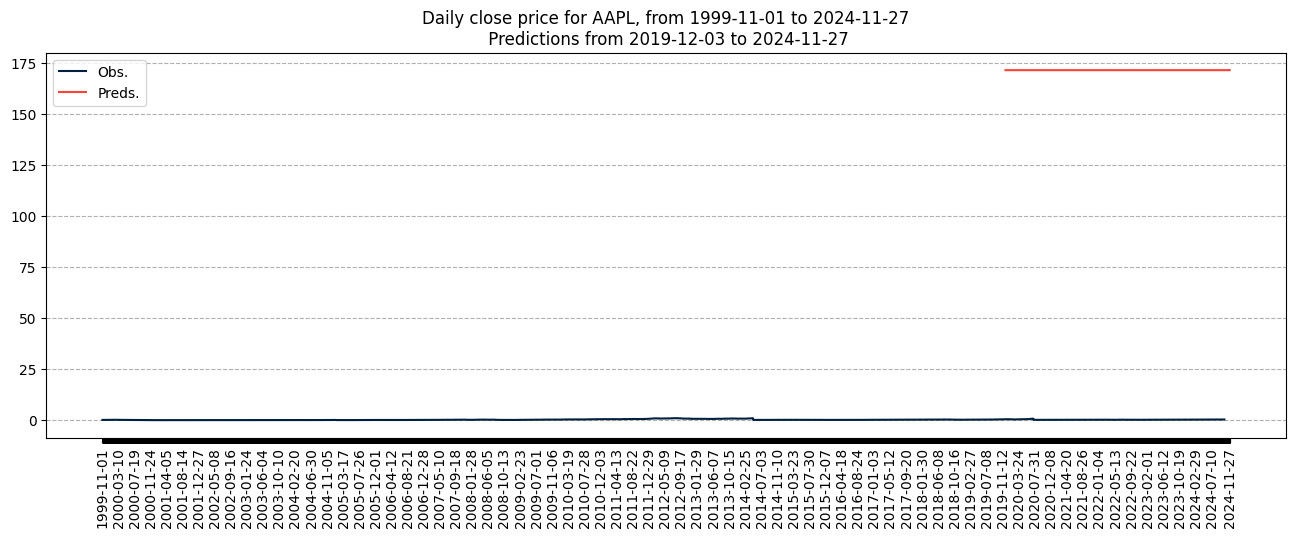

In [173]:
apple_model.plot_data(predictions)

In [125]:
class Config():
    def __init__(self,key,ticker,outputsize="full", data={"window size":20, "train_size":0.8,'val_size':0.75},
                 plots={"show_plots":True,"xtick_interval":90,"color_actual": "#001f3f","color_train": "#3D9970","color_val": "#0074D9",
                        "color_pred_train": "#3D9970","color_pred_val": "#0074D9","color_pred_test": "#FF4136",},
                        model={"input_size": 1, "num_lstm_layers": 2, "lstm_size": 32, "dropout": 0.2},
                        training={"device": "cpu", "batch_size": 64, "num_epoch": 100, "learning_rate": 0.01, "scheduler_step_size": 40}):
        self.key=key
        self.ticker=ticker
        self.outputsize=outputsize
        self.data=data
        self.plots=plots
        self.model=model
        self.training=training
        self.colname=None
        self.data_x,self.data_y,self.scaler=None,None,None
        self.df=self.get_data()
    def __repr__(self):
        out=f"Config:\n-Ticker : {self.ticker}\n-outputsize : {self.outputsize}\n-data : {self.data}\n"
        out+=f"-plots : {self.plots}\n-model : {self.model}\n-training : {self.training}"
        return out
    def get_data(self):
        if self.ticker+'.csv' in os.listdir():
            return pd.read_csv(f"{self.ticker}.csv",index_col=0)
        else:
            ts = TimeSeries(key=self.key, output_format='pandas')
            data, _ = ts.get_daily(symbol=self.ticker,outputsize=self.outputsize)
            data.columns=["Open","High","Low","Close","Volume"]
            data.index = data.index.strftime('%Y-%m-%d')
            data=data.iloc[::-1]
            #data_date=data.index.to_list()
            #data_date.reverse()
            data.to_csv(f"{self.ticker}.csv")
        return pd.read_csv(f"{self.ticker}.csv", index_col=0)
    def plot(self):
        data=pd.read_csv(f"{self.ticker}.csv")
        num_data_points = len(data.date)
        display_date_range = "from " + data.date[0] + " to " + data.date[num_data_points-1]
        print("Number data points:", num_data_points, display_date_range)
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data.date, data.Close, color=self.plots["color_actual"])
        xticks = [data.date[i] if ((i%self.plots["xtick_interval"]==0 and (num_data_points-i) > self.plots["xtick_interval"]) or i==num_data_points-1) 
                    else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close price for " + companies_dict[self.ticker].ticker + ", " + display_date_range)
        plt.grid(which='major', axis='y', linestyle='--')
        plt.show()
    def __dict__(self):
        return {'ticker':self.ticker,'outputsize':self.outputsize,'data':self.data,'plot':self.plots,'model':self.model,'training':self.training}
    def dump(self):
        with open(F"{self.ticker}"+'_config.json', 'w') as f:
            json.dump(self.__dict__(), f, indent=4)
    def preprocess_data(self,colname):
        if self.colname is not None:
            return self.data_x,self.data_y,self.scaler
        self.colname=colname
        df=self.get_data()
        window_size=self.data["window size"]
        scaler = MinMaxScaler(feature_range=(0, 1))
        data = scaler.fit_transform(df[colname].values.reshape(-1,1))
        data_x, data_y = [], []
        for i in range(len(data) - window_size):
            data_x.append(data[i:(i + window_size), 0])
            data_y.append(data[i + window_size, 0])
        data_x = torch.tensor(data_x, dtype=torch.float32)  # Convert to tensor
        data_x= data_x.unsqueeze(-1)  # Add input_size dimension (now 3D: (num_samples, sequence_length, input_size))
        data_y = torch.tensor(data_y, dtype=torch.float32)
        print(f"Preprocessed data shapes - X: {data_x.shape}, y: {data_y.shape}")  # Debugging output
        self.data_x,self.data_y,self.scaler=data_x,self.data_y,self.scaler=data_x,data_y,scaler
        return data_x,data_y, scaler



In [126]:
boeing=companies_dict["BA"]
config=Config(API_KEY,boeing.ticker)
config.dump()
df=config.get_data()
print(f"df.shape={df.shape} from {df.index[0]} to {df.index[-1]}, with columns ={df.columns.tolist()}")
df.head()

AttributeError: 'tuple' object has no attribute 'ticker'

In [ ]:
data_x,data_y,scaler=config.preprocess_data("Close")
print(config.colname)

## Preparation des données
- minmaxscaler sur colonne à prédire;
- en fonction de la largeur de la fenêtre glissante, générer les données d'entraînement;

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, lstm_size, num_lstm_layers, dropout):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_size, lstm_size, num_lstm_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(lstm_size, 1)  # Output layer for regression

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM outputs: (output, (h_n, c_n))
        out = out[:, -1, :]  # Take the output of the last timestep
        return self.fc(out)

In [ ]:
def train_rnn(config):
    if config.colname is None: 
        print(f"You need to preprocess config first, defining a colname to extract data from")
        return None,None
    # Extract config parameters
    device = config.training["device"]
    train_split = config.data["train_size"]
    val_split = config.data["val_size"]
    batch_size = config.training["batch_size"]
    num_epoch = config.training["num_epoch"]
    learning_rate = config.training["learning_rate"]
    scheduler_step_size = config.training["scheduler_step_size"]

    # Prepare data
    X, y, scaler = config.data_x,config.data_y,config.scaler
    train_idx = int(len(X) * train_split)
    val_idx = int(train_idx*val_split)
    dataset=TensorDataset(X,y)
    train_dataset = TensorDataset(X[:val_idx], y[:val_idx])
    val_dataset = TensorDataset(X[val_idx:train_idx], y[val_idx:train_idx])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model, optimizer, and scheduler
    model = RNN(input_size=X.shape[2], 
                lstm_size=config.model["lstm_size"], 
                num_lstm_layers=config.model["num_lstm_layers"], 
                dropout=config.model["dropout"]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=0.1)

    # Training loop
    for epoch in range(num_epoch):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch.unsqueeze(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                val_loss += criterion(output, y_batch.unsqueeze(-1)).item()
        val_loss /= len(val_loader)

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return model, dataset, scaler



In [ ]:
# Train the model
%time trained_model, dataset, scaler = train_rnn(config)

In [ ]:
def predict_rnn(model, dataloader, scaler, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():
        for X_batch, _ in dataloader:  # Labels (`_`) are not needed for predictions
            X_batch = X_batch.to(device)
            preds = model(X_batch)
            predictions.append(preds.cpu().numpy())  # Collect predictions

    # Flatten predictions and invert scaling
    predictions = np.concatenate(predictions).flatten()
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()  # Invert scaling
    return predictions

In [ ]:
date_debut_pred='2022-11'
split_idx = list(df.index).index(date_debut_pred+'-01')#int(len(config.data_x) * config.data["train_size"])
X_test = dataset.tensors[0][split_idx:]
y_test = dataset.tensors[1][split_idx:]

# Create a new TensorDataset
test_dataset = TensorDataset(X_test, y_test)
print(f"len(dataset)={len(dataset)}, len(test_dataset)={len(test_dataset)}")
test_loader = DataLoader(test_dataset, batch_size=config.training["batch_size"])

predictions = predict_rnn(trained_model, test_loader, scaler, config.training["device"])
print(list(zip(np.array(predictions[:10]).astype("float32"),df.Close[split_idx+config.data["window size"]:][:10])))

In [ ]:
print(f"len(predictions)={len(predictions)}, len(data_y[split_idx:])={len(config.data_y[split_idx:])}, len(df.index[split_idx:])={len(df.index[split_idx:])}")

In [ ]:
%%time
# on va afficher la moyenne mensuelle jusqu'au 2024-10-01 (en forward) des valeurs observées et on greffe dessus les valeurs prédits
#pour cela il faut définir les années, leurs mois, leurs jours
ymd=['year','month','day']
dates={i:{k:v for k,v in list(zip(ymd,date.split('-')))} for i,date in enumerate(df.index)}
years=np.unique([dates[i]['year'] for i in dates])
months={year:np.unique([dates[i]['month'] for i in dates if dates[i]['year']==year]) for year in years}
days={(year,month):[dates[i]['day'] for i in dates if (dates[i]['year'],dates[i]['month'])==(year,month)] for year in years for month in months[year]}

In [ ]:
%%time 
moyennes_mensuelles={year+'-'+month:np.mean([df.loc[year+'-'+month+'-'+day].Close for day in days[(year,month)]]) for year,month in days}
moyennes_predites={year+'-'+month:np.mean([df.loc[year+'-'+month+'-'+day].Close for day in days[(year,month)]]) 
                   for year,month in days if year+'-'+month+'-'>=date_debut_pred}


In [ ]:
plt.figure(figsize=(16,4))
plt.plot(moyennes_mensuelles.keys(),moyennes_mensuelles.values(), label="Moyennes M obs.")
plt.scatter(moyennes_predites.keys(),moyennes_predites.values(), color='r',label="Moyennes M pred..")
clefs=sorted(list(moyennes_mensuelles))
xticks=[clefs[i] for i in range(0,len(clefs),6)]
print(type(xticks[0]))
plt.xticks(xticks,rotation=90)
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Plot of Close with Semi-Annual Ticks')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()
plt.show()

In [ ]:
plt.figure(figsize=(16, 5)) 

plt.plot(df.index[split_idx+config.data["window size"]:], np.array(predictions), label='Predictions')
plt.plot(df.index[split_idx+config.data["window size"]:],df.Close[split_idx+config.data["window size"]:], label='True Values')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
np.array(config.data_y).shape